# Proceso EDA de los datos del Titanic - Azure Synapse Analytics

#### Vanessa Rodríguez Horcajo y José Antonio Martínez Martínez.

El objetivo de esta práctica consiste en desarrollar un modelo de clasificiación capaz de, dados unos datos relativos al accidente del Titanic, predecir si un determinado pasajero sobrevivirá o no.

Este objetivo principal estará compuesto por dos tareas: 
1. El análisis y preparación de los datos, realizado en este notebook.
2. El desarrollo del propio modelo de clasificación que se realizará empleando Azure ML.

En el presente notebook se comprende solo la primera de las dos mencionadas tareas.

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql.functions import mean 

StatementMeta(myspark4lab, 10, 2, Finished, Available)

## Carga de datos

In [2]:
ruta_archivo = "abfss://fsvrhjamm@datalakevrhjamm.dfs.core.windows.net/PracticaTitanic/DatosPracticaTitanic.csv"
df = spark.read.option("header", "true").option("inferSchema", "true").csv(ruta_archivo)

StatementMeta(myspark4lab, 10, 3, Finished, Available)

In [3]:
df.show()

StatementMeta(myspark4lab, 10, 4, Finished, Available)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [4]:
df.printSchema()

StatementMeta(myspark4lab, 10, 5, Finished, Available)

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [5]:
num_filas = df.count()
print("Número de filas:", num_filas)
print("Número de columnas:", len(df.columns))

StatementMeta(myspark4lab, 10, 6, Finished, Available)

Número de filas: 891
Número de columnas: 12


Tal y como se puede observar tras la carga de los datos, se dispone de la siguiente información relativa a cada pasajero:

- `PassengerId`: Identificador del pasajero.
- `Survived`: Si el pasajero en cuestión sobrevivió (1) o no (0) a la catástrofe del Titanic.
- `Pclass`: Clase del ticket: Primera, segunda o tercera clase. 
- `Name`: Nombre de la persona cuya supervivencia se está analizando.
- `Sex`: Género de la persona cuya supervivencia se está analizando.
- `Age`: Edad.
- `SibSp`: Número de hermanos y/o cónyuges presentes abordo del Titanic.
- `Parch`: Número de padres y/o progenie abordo del Titanic.
- `Ticket`: Número de ticket del pasajero.
- `Fare`: Tarifa del pasajero.
- `Cabin`: Identificador de la cabina en la que se alojaba.
- `Embarked`: Puerto de embarcación: C = Cherbourg, Q = Queenstown, S = Southampton.

## Análisis estadístico de los datos.

Antes de proceder con el propio análisis de los datos procederemos a eliminar algunas columnas que no se consideran de interés de cara a la consecución de nuestros objetivos.

Así pues se eliminan las columnas `PassengerId`, `Name`, `Ticket` y `Cabin`. 

In [6]:
columnas_a_eliminar = ["PassengerId", "Name", "Ticket", "Cabin"]
df = df.drop(*columnas_a_eliminar)
 
df.show()

StatementMeta(myspark4lab, 10, 7, Finished, Available)

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
|       1|     3|female|26.0|    0|    0|  7.925|       S|
|       1|     1|female|35.0|    1|    0|   53.1|       S|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|
|       0|     3|  male|null|    0|    0| 8.4583|       Q|
|       0|     1|  male|54.0|    0|    0|51.8625|       S|
|       0|     3|  male| 2.0|    3|    1| 21.075|       S|
|       1|     3|female|27.0|    0|    2|11.1333|       S|
|       1|     2|female|14.0|    1|    0|30.0708|       C|
|       1|     3|female| 4.0|    1|    1|   16.7|       S|
|       1|     1|female|58.0|    0|    0|  26.55|       S|
|       0|     3|  male|20.0|    0|    0|   8.05|       S|
|       0|     3|  male|39.0|    1|    5| 31.275|       

In [7]:
df.describe().show()

StatementMeta(myspark4lab, 10, 8, Finished, Available)

+-------+-------------------+------------------+------+------------------+------------------+-------------------+-----------------+--------+
|summary|           Survived|            Pclass|   Sex|               Age|             SibSp|              Parch|             Fare|Embarked|
+-------+-------------------+------------------+------+------------------+------------------+-------------------+-----------------+--------+
|  count|                891|               891|   891|               714|               891|                891|              891|     889|
|   mean| 0.3838383838383838| 2.308641975308642|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824| 32.2042079685746|    null|
| stddev|0.48659245426485753|0.8360712409770491|  null|14.526497332334035|1.1027434322934315| 0.8060572211299488|49.69342859718089|    null|
|    min|                  0|                 1|female|              0.42|                 0|                  0|              0.0|       C|
|    max|    

Para representar las distintas variables gráficamente es necesario transformar los datos a formato Dataframe de Pandas por lo que se procederá a ello ahora.

In [8]:
df_pd = df.toPandas()

StatementMeta(myspark4lab, 10, 9, Finished, Available)

### Análisis de Survived

Se trata de la variable a predecir. Toma valores 0 o 1 dependiendo de si los pasajaeros sobrevivieron (1) o no (0).

A continuación se procederá a analizar si presenta algún valor nulo y cómo se distribuyen las clases.

In [9]:
aux = df.filter(df["Survived"].isNull())
 
print(f"Número de filas en las que Survived es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 10, Finished, Available)

Número de filas en las que Survived es nulo: 0


StatementMeta(myspark4lab, 10, 11, Finished, Available)

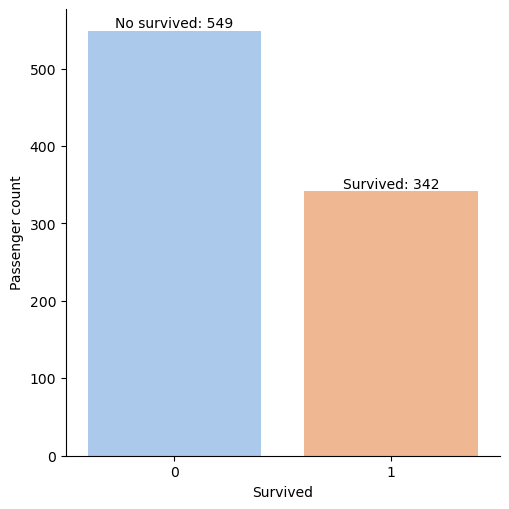

In [10]:
grafico = sns.catplot(data=df_pd, x="Survived", kind="count", palette='pastel')
 
conteo = df_pd['Survived'].value_counts()
colores_barras = [bar.get_facecolor() for bar in grafico.ax.patches]
 
for i, patch in enumerate(grafico.ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    texto = f'{"Survived" if conteo.index[i] == 1 else "No survived"}: {conteo.iloc[i]}'
    grafico.ax.annotate(texto, (x, y), ha='center', va='bottom', color='black')
 
plt.xlabel('Survived')
plt.ylabel('Passenger count')
 
plt.show()

In [11]:
print(f"Porcentaje de supervivientes: {(df_pd[df_pd.Survived == 1].shape[0] / num_filas * 100):.2f}%")
print(f"Porcentaje de no supervivientes: {(df_pd[df_pd.Survived == 0].shape[0] / num_filas * 100):.2f}%")

StatementMeta(myspark4lab, 10, 12, Finished, Available)

Porcentaje de supervivientes: 38.38%
Porcentaje de no supervivientes: 61.62%


Del anterior análisis se puede concluir que no hay valores faltantes y que los datos están algo sesgados hacia la no supervivencia de los pasajeros: Hay un 23.24% más de pasajeros no supervivientes.

### Análisis de Pclass

Se trata de la clase de los pasajeros. Toma valores 1, 2, 3 dependiendo de si los pasajaeros eran de primera, segunda o tercera clase.

A continuación se procederá a analizar si presenta algún valor nulo y cómo se distribuyen las clases.

In [12]:
aux = df.filter(df["Pclass"].isNull())
 
print(f"Número de filas en las que Pclass es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 13, Finished, Available)

Número de filas en las que Pclass es nulo: 0


StatementMeta(myspark4lab, 10, 14, Finished, Available)

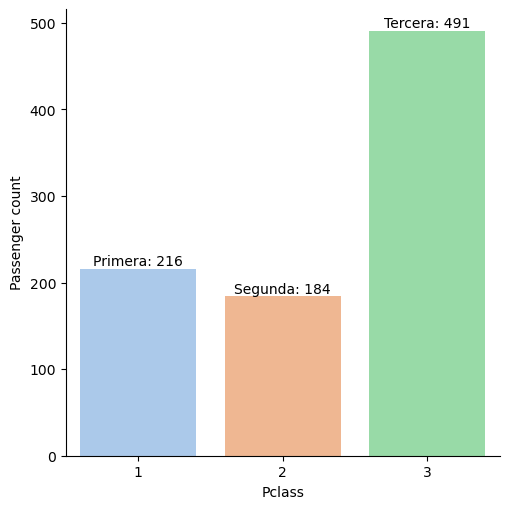

In [13]:
grafico = sns.catplot(data=df_pd, x="Pclass", kind="count", palette='pastel')
 
conteo = df_pd['Pclass'].value_counts().sort_index()
colores_barras = [bar.get_facecolor() for bar in grafico.ax.patches]

lista_clases = ["Primera", "Segunda", "Tercera"]
 
for i, patch in enumerate(grafico.ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    texto = f'{lista_clases[conteo.index[i]-1]}: {conteo.iloc[i]}'
    grafico.ax.annotate(texto, (x, y), ha='center', va='bottom', color='black')
 
plt.xlabel('Pclass')
plt.ylabel('Passenger count')
 
plt.show()

Del anterior análisis se puede concluir que no hay valores faltantes y que los datos están desbalanceados: La mayoría de los pasajeros pertenecen a tercera clase.

### Análisis de Sex

Se trata del género de los pasajeros. Toma valor `male` para hombres y `female` para mujeres.

A continuación se procederá a analizar si presenta algún valor nulo y cómo se distribuyen las clases.

In [14]:
aux = df.filter(df["Sex"].isNull())
 
print(f"Número de filas en las que Sex es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 15, Finished, Available)

Número de filas en las que Sex es nulo: 0


StatementMeta(myspark4lab, 10, 16, Finished, Available)

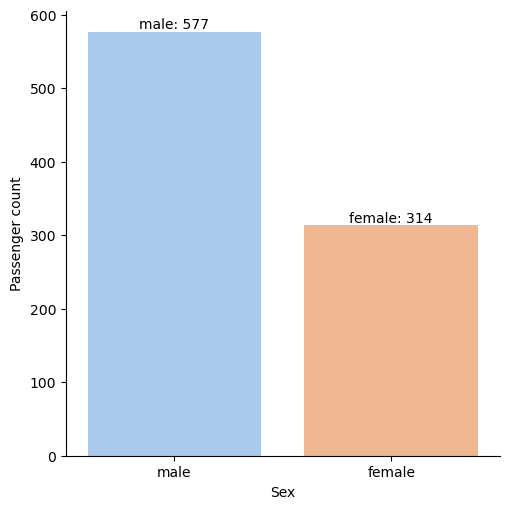

In [15]:
grafico = sns.catplot(data=df_pd, x="Sex", kind="count", palette='pastel')
 
conteo = df_pd['Sex'].value_counts()
colores_barras = [bar.get_facecolor() for bar in grafico.ax.patches]
 
for i, patch in enumerate(grafico.ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    texto = f'{conteo.index[i]}: {conteo.iloc[i]}'
    grafico.ax.annotate(texto, (x, y), ha='center', va='bottom', color='black')
 
plt.xlabel('Sex')
plt.ylabel('Passenger count')
 
plt.show()

In [16]:
hombre = "male"
mujer = "female"
print(f"Porcentaje de hombres: {(df_pd[df_pd.Sex == hombre].shape[0] / num_filas * 100):.2f}%")
print(f"Porcentaje de mujeres: {(df_pd[df_pd.Sex == mujer].shape[0] / num_filas * 100):.2f}%")

StatementMeta(myspark4lab, 10, 17, Finished, Available)

Porcentaje de hombres: 64.76%
Porcentaje de mujeres: 35.24%


Del anterior análisis se puede concluir que no hay valores faltantes y que los datos están desbalanceados: Hay un 29.52% más de hombres que de mujeres.

### Análisis de Age

Se trata de la edad de los pasajeros.

A continuación se procederá a analizar si presenta algún valor nulo y cómo se distribuyen las clases.

In [17]:
aux = df.filter(df["Age"].isNull())
 
print(f"Número de filas en las que Age es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 18, Finished, Available)

Número de filas en las que Age es nulo: 177


Como se aprecian valores faltantes, hemos decidido emplear la media para subsanar los mismos.

In [18]:
mean_age = df.select(mean(df['Age'])).collect()[0][0] 
mean_age = round(mean_age)
mean_age

StatementMeta(myspark4lab, 10, 19, Finished, Available)

30

In [19]:
df = df.fillna(mean_age, subset=['Age'])

StatementMeta(myspark4lab, 10, 20, Finished, Available)

In [20]:
aux = df.filter(df["Age"].isNull())
 
print(f"Número de filas en las que Age es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 21, Finished, Available)

Número de filas en las que Age es nulo: 0


Por consistencia se eliminarán también los NaN en pandas.

In [21]:
df_pd = df.toPandas()

StatementMeta(myspark4lab, 10, 22, Finished, Available)

StatementMeta(myspark4lab, 10, 23, Finished, Available)

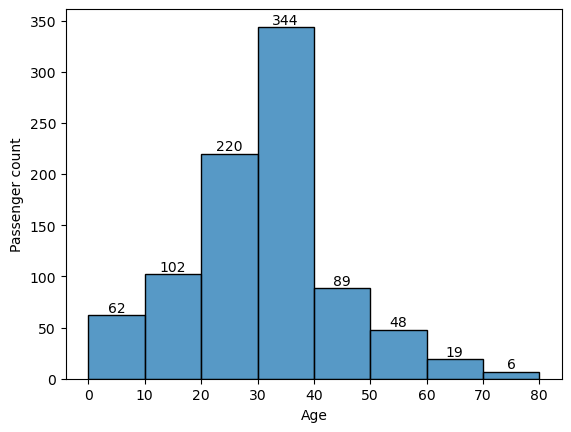

In [22]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
 
df_pd['Age_Bin'] = pd.cut(df_pd['Age'], bins=bins, right=False)
 
conteo_por_bin = df_pd.groupby('Age_Bin').size().reset_index(name='Count')
 
grafico = sns.histplot(data=df_pd, x="Age", palette='pastel', bins=bins) 
 
for i, bar in enumerate(grafico.containers[0]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y, conteo_por_bin['Count'].iloc[i], ha='center', va='bottom', color='black')
 
plt.xlabel('Age')
plt.ylabel('Passenger count')
plt.show()

Del anterior análisis se puede concluir que ya no hay valores faltantes. Se debe tener en cuenta que, para solucionar el problema de los valores faltantes, se ha recurrido al valor medio de la edad. Al haberse utilizado esta estrategia es posible que se haya difuminado parte de la información de la edad por lo que, en caso de que el modelo no funcionase correctamente, habría que volver a analizar esta variable.

In [23]:
df_pd.drop(columns=["Age_Bin"], inplace=True)

StatementMeta(myspark4lab, 10, 24, Finished, Available)

### Análisis de SibSp (Siblings and Spouse)

Se trata del número de hermanos y/o conyuges presentes abordo del Titanic.

A continuación se procederá a analizar si presenta algún valor nulo y cómo se distribuyen las clases.

In [24]:
aux = df.filter(df["SibSp"].isNull())
 
print(f"Número de filas en las que SibSp es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 25, Finished, Available)

Número de filas en las que SibSp es nulo: 0


StatementMeta(myspark4lab, 10, 26, Finished, Available)

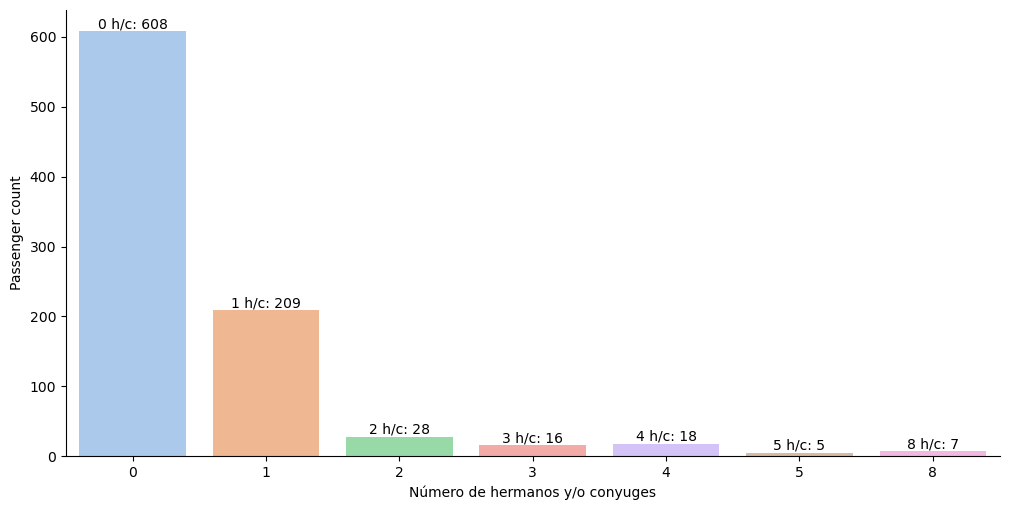

In [25]:
grafico = sns.catplot(data=df_pd, x="SibSp", kind="count", palette='pastel', aspect=2)
 
conteo = df_pd['SibSp'].value_counts().sort_index()
colores_barras = [bar.get_facecolor() for bar in grafico.ax.patches]
 
for i, patch in enumerate(grafico.ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    texto = f'{conteo.index[i]} h/c: {conteo.iloc[i]}'
    grafico.ax.annotate(texto, (x, y), ha='center', va='bottom', color='black')
 
plt.xlabel('Número de hermanos y/o conyuges')
plt.ylabel('Passenger count')
 
plt.show()

Del anterior análisis se puede concluir que no hay valores faltantes y que los datos están desbalanceados: Hay un 68.24% de los pasajeros que viajaba sin hermanos o conyuges a bordo.

### Análisis de Parch (Parents and Children)

Se trata del número de padres y/o hijos presentes abordo del Titanic.

A continuación se procederá a analizar si presenta algún valor nulo y cómo se distribuyen las clases.

In [26]:
aux = df.filter(df["Parch"].isNull())
 
print(f"Número de filas en las que Parch es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 27, Finished, Available)

Número de filas en las que Parch es nulo: 0


StatementMeta(myspark4lab, 10, 28, Finished, Available)

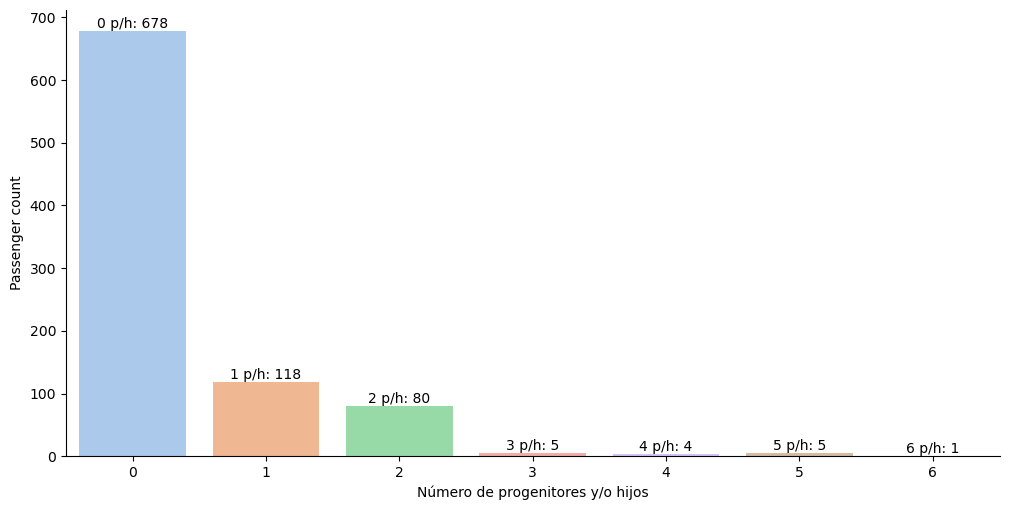

In [27]:
grafico = sns.catplot(data=df_pd, x="Parch", kind="count", palette='pastel', aspect=2)
 
conteo = df_pd['Parch'].value_counts().sort_index()
colores_barras = [bar.get_facecolor() for bar in grafico.ax.patches]
 
for i, patch in enumerate(grafico.ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    texto = f'{conteo.index[i]} p/h: {conteo.iloc[i]}'
    grafico.ax.annotate(texto, (x, y), ha='center', va='bottom', color='black')
 
plt.xlabel('Número de progenitores y/o hijos')
plt.ylabel('Passenger count')
 
plt.show()

Del anterior análisis se puede concluir que no hay valores faltantes y que los datos están desbalanceados: Hay un 76.1% de los pasajeros viajaba sin progenitores o hijos a bordo.

A partir de esta información, en conjunción con el análisis de SibSp, se puede concluir que la mayoría de pasajeros viajaban solos (o por lo menos no con familiares).

### Análisis de Fare

Se trata de la tarifa de los pasajeros.

A continuación se procederá a analizar si presenta algún valor nulo y cómo se distribuyen las clases.

In [28]:
aux = df.filter(df["Fare"].isNull())
 
print(f"Número de filas en las que Fare es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 29, Finished, Available)

Número de filas en las que Fare es nulo: 0


StatementMeta(myspark4lab, 10, 30, Finished, Available)

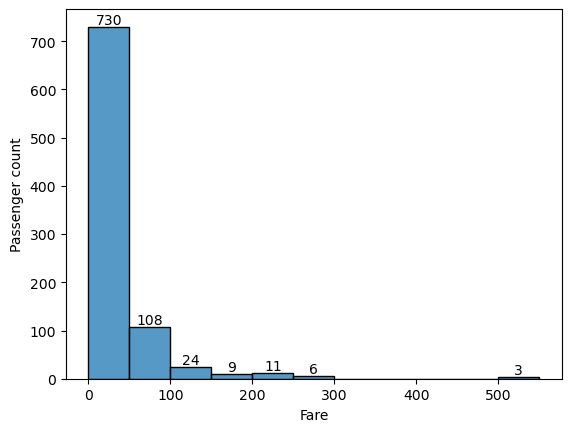

In [29]:
bins = [50*i for i in range(12)]
 
df_pd['Fare_Bin'] = pd.cut(df_pd['Fare'], bins=bins, right=False)
 
conteo_por_bin = df_pd.groupby('Fare_Bin').size().reset_index(name='Count')
 
grafico = sns.histplot(data=df_pd, x="Fare", palette='pastel', bins=bins) 
 
for i, bar in enumerate(grafico.containers[0]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()


    if conteo_por_bin['Count'].iloc[i] != 0:
        plt.text(x, y, conteo_por_bin['Count'].iloc[i], ha='center', va='bottom', color='black')
 
plt.xlabel('Fare')
plt.ylabel('Passenger count')
plt.show()

In [30]:
for rango in sorted(df_pd.Fare_Bin.unique()):
    precio_medio = df_pd[ df_pd.Fare_Bin == rango ].Fare.mean()
    num_pasajeros = df_pd[ df_pd.Fare_Bin == rango ].shape[0]
    print(f"Rango {rango}, precio medio: {precio_medio:.2f} libras. Número de pasajeros en este rango: {num_pasajeros}.")

print(f"Media global: {df_pd.Fare.mean():.2f} libras.")

StatementMeta(myspark4lab, 10, 31, Finished, Available)

Rango [0, 50), precio medio: 15.50 libras. Número de pasajeros en este rango: 730.
Rango [50, 100), precio medio: 69.13 libras. Número de pasajeros en este rango: 108.
Rango [100, 150), precio medio: 122.09 libras. Número de pasajeros en este rango: 24.
Rango [150, 200), precio medio: 155.15 libras. Número de pasajeros en este rango: 9.
Rango [200, 250), precio medio: 224.77 libras. Número de pasajeros en este rango: 11.
Rango [250, 300), precio medio: 262.79 libras. Número de pasajeros en este rango: 6.
Rango [500, 550), precio medio: 512.33 libras. Número de pasajeros en este rango: 3.
Media global: 32.20 libras.


In [31]:
df_pd.drop(columns=["Fare_Bin"], inplace=True)

StatementMeta(myspark4lab, 10, 32, Finished, Available)

Del anterior análisis se puede concluir que no hay valores faltantes y que los datos están desbalanceados: Un 81.9% de los pasajeros totales pagaron billites relativamente baratos (15.50 libras) mientras que hay una minoría, un 0.33%, que pagaron de media 512.33 libras.
De la gran diferencia de precio y número de pasajeros anterior se puede dilucidar que quizas estos pasajeros se traten de outliers que podría convenir eliminar.

### Análisis de Embarked

Se trata del puerto de embarcación de los pasajeros.

A continuación se procederá a analizar si presenta algún valor nulo y cómo se distribuyen las clases.

In [32]:
aux = df.filter(df["Embarked"].isNull())
 
print(f"Número de filas en las que Embarked es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 33, Finished, Available)

Número de filas en las que Embarked es nulo: 2


Parece haber dos muestras sin embarked. Para solucionarlo se procederá a emplear el puerto más común como relleno.

In [33]:
moda_Embarked = df_pd.Embarked.mode()[0]
moda_Embarked

StatementMeta(myspark4lab, 10, 34, Finished, Available)

'S'

In [34]:
df = df.fillna(moda_Embarked, subset=['Embarked'])

StatementMeta(myspark4lab, 10, 35, Finished, Available)

In [35]:
aux = df.filter(df["Embarked"].isNull())
 
print(f"Número de filas en las que Embarked es nulo: {aux.count()}")

StatementMeta(myspark4lab, 10, 36, Finished, Available)

Número de filas en las que Embarked es nulo: 0


Por consistencia también se rellenará el DataFrame de Pandas.

In [36]:
df_pd = df.toPandas()

StatementMeta(myspark4lab, 10, 37, Finished, Available)

StatementMeta(myspark4lab, 10, 38, Finished, Available)

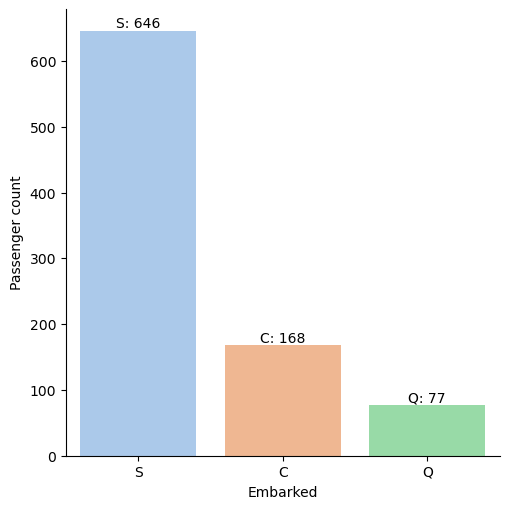

In [37]:
grafico = sns.catplot(data=df_pd, x="Embarked", kind="count", palette='pastel')
 
conteo = df_pd['Embarked'].value_counts()
colores_barras = [bar.get_facecolor() for bar in grafico.ax.patches]
 
for i, patch in enumerate(grafico.ax.patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    texto = f'{conteo.index[i]}: {conteo.iloc[i]}'
    grafico.ax.annotate(texto, (x, y), ha='center', va='bottom', color='black')
 
plt.xlabel('Embarked')
plt.ylabel('Passenger count')
 
plt.show()

Del anterior análisis se puede concluir que no hay valores faltantes y que los datos están desbalanceados: 

Hay un 72.5% de los pasajeros que subieron a bordo en el puerto de Southampton, un 18.85% en Cherbourg y un 8.65% en el de Queenstown.

### Salvado final de los datos

Habiendo analizado y limpiado ya los datos, procedemos a su salvado en Azure para poder utilizarlos posteriormente en el entrenamiento del modelo o en otros menesteres.

In [39]:
df.write.csv("abfss://fsvrhjamm@datalakevrhjamm.dfs.core.windows.net/PracticaTitanic/DatosTitanicTratados.csv", 
header=True, mode="overwrite")

StatementMeta(myspark4lab, 10, 40, Finished, Available)

Esta celda de código se utiliza para crear una base de datos con los datos del Titanic a fin de intentar crear una conexión con PowerBi.

### Análisis de correlación entre las variables

De cara a determinar si existe alguna relación entre las variables existentes que deba tenerse en cuenta, hemos optado por realizar un análisis de correlación y visualizar la distribución de cada pareja de variables de manera gráfica.

In [42]:
df_pd.dtypes

StatementMeta(myspark4lab, 7, 43, Finished, Available)

Survived      int32
Pclass        int32
Sex          object
Age         float64
SibSp         int32
Parch         int32
Fare        float64
Embarked     object
dtype: object

StatementMeta(myspark4lab, 7, 44, Finished, Available)

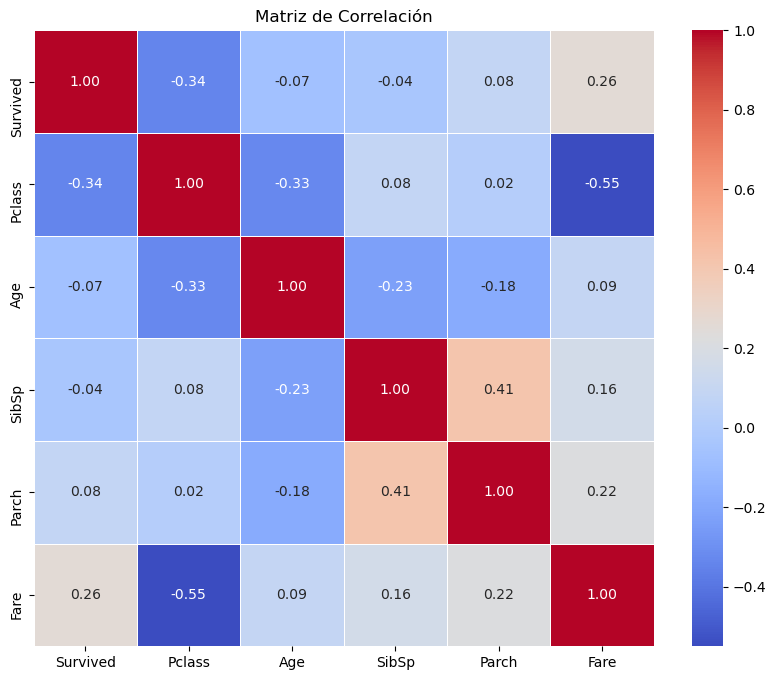

In [43]:
columnas_numericas = df_pd.select_dtypes(include=['float64', 'int32'])
correlation_matrix = columnas_numericas.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

Algunas de las correlaciones más interesantes que se pueden observar son:
- La correlación negativa entre `Pclass` y `Fare`. Indica que, cuanto mayor es el número de clase más barato es el billete. Aunque esto en un principio pueda resultar confuso hay que recordar que la primera clase es, numéricamente, inferior a la tercera clase.
- La correlación positiva entre `Parch` y `SibSp`. Esta correlación indica que, cuando una persona es acompañada por sus padres o hijos, también suele estar acompañada por sus hermanos y conyuges.
- La correlación negativa entre `Pclass` y `Survived`. Siguiendo la misma logica explicada en la primera relación, a mejor clase más probabilidades de sobrevivir.

StatementMeta(myspark4lab, 7, 45, Finished, Available)

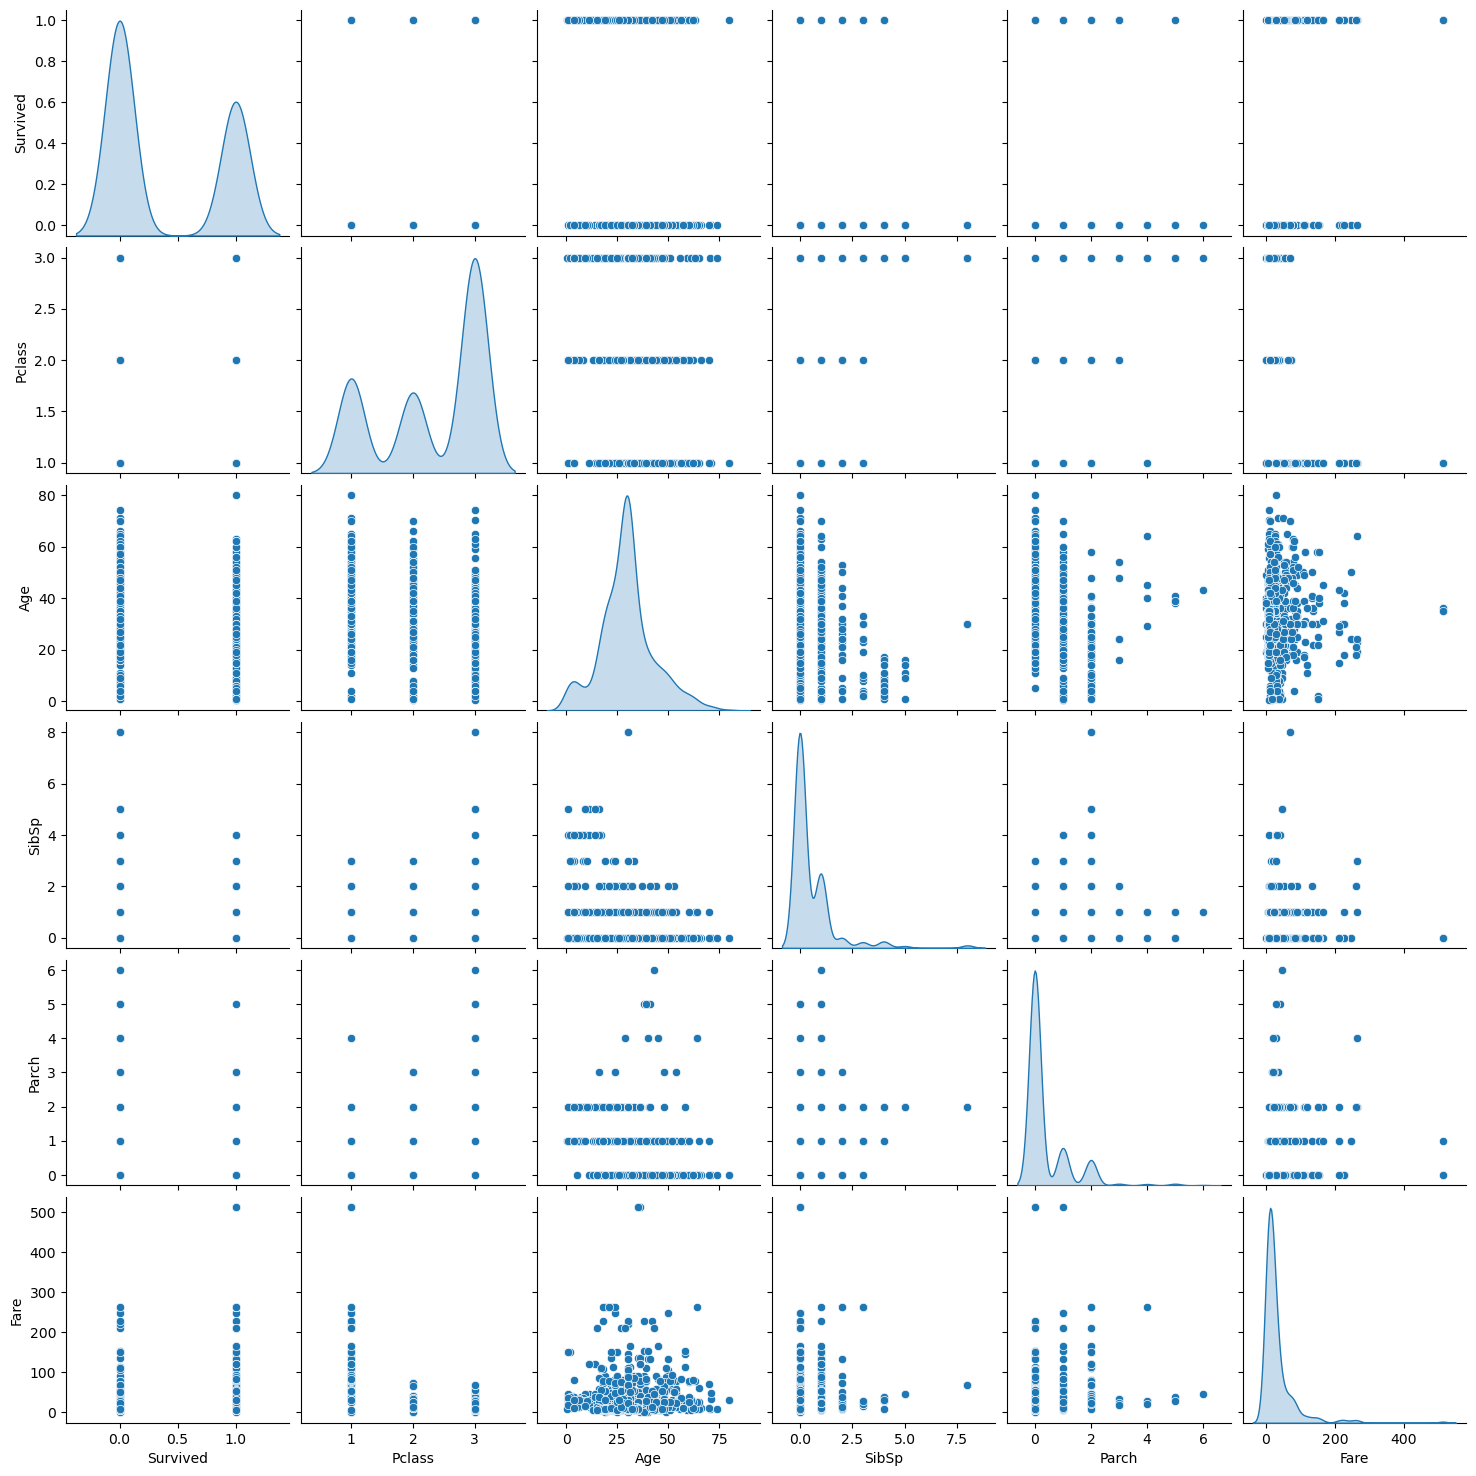

In [44]:
sns.pairplot(data=df_pd, diag_kind='kde')

## Análisis en profundidad de los datos: SQL

En esta sección se realizarán algunas consultas SQL sobre los datos a fin de investigar algunas tendencias y posibles relaciones entre las distintas variables.

In [45]:
df.createOrReplaceTempView("pasajeros_titanic")

StatementMeta(myspark4lab, 7, 46, Finished, Available)

#### Tasa de supervivencia por género:

In [56]:
%%sql
SELECT Sex, COUNT(*) AS total_pasajeros, SUM(Survived) AS total_sobrevivieron, round(SUM(Survived)*100.0/COUNT(*), 2) AS tasa_supervivencia_porcentaje
FROM pasajeros_titanic
GROUP BY Sex

StatementMeta(myspark4lab, 7, 57, Finished, Available)

<Spark SQL result set with 2 rows and 4 fields>

De los resultados anteriores se puede concluir que las mujeres tuvieron una mayor tasa de supervivencia que los hombres.

#### Tasa de supervivencia por clase de ticket:

In [57]:
%%sql
SELECT Pclass,
    COUNT(*) AS total_pasajeros,
    SUM(Survived) AS total_sobrevivieron,
    round(SUM(Survived)*100.0 / COUNT(*), 2) AS tasa_supervivencia_porcentaje
FROM pasajeros_titanic
GROUP BY Pclass

StatementMeta(myspark4lab, 7, 58, Finished, Available)

<Spark SQL result set with 3 rows and 4 fields>

De los resultados anteriores se puede concluir que la supervivencia de los pasajeros estaba ligada a su clase. A mayor clase mayor supervivencia.

#### Edad promedio de los pasajeros que sobrevivieron y los que no sobrevivieron:

In [60]:
%%sql
SELECT Survived,
    round(AVG(Age), 0) AS edad_promedio
FROM pasajeros_titanic
GROUP BY Survived

StatementMeta(myspark4lab, 7, 61, Finished, Available)

<Spark SQL result set with 2 rows and 2 fields>

De los resultados anteriores se puede concluir que los pasajeros que sobrevivieron eran, de media, ligeramente más jovenes (1 año).

#### Tarifa promedio pagada por clase de ticket y puerto de embarque:


In [61]:
%%sql
SELECT Embarked,
    round(AVG(Fare), 2) AS tarifa_promedio
FROM pasajeros_titanic
GROUP BY Embarked

StatementMeta(myspark4lab, 7, 62, Finished, Available)

<Spark SQL result set with 3 rows and 2 fields>

De los resultados anteriores se puede concluir que el embarcadero con la mayor tarifa es "C" (Cherbourg).

In [64]:
%%sql
SELECT Embarked, Pclass, count(*) as total_pasajeros
FROM pasajeros_titanic
GROUP BY Embarked, Pclass
ORDER BY Embarked

StatementMeta(myspark4lab, 7, 65, Finished, Available)

<Spark SQL result set with 9 rows and 3 fields>

Con esta nueva observación se puede explicar que Cherbourg sea el embarcadero con la tarifa media más alta, ya que en ese embarcadero se subieron más personas de primera clase que del resto de clases combinadas, elevando el precio de la tarifa media.

#### Edad promedio de los pasajeros por clase de ticket y género:

In [66]:
%%sql
SELECT Pclass, Sex, round(AVG(Age), 0) AS edad_promedio
FROM pasajeros_titanic
GROUP BY Pclass, Sex
ORDER BY Pclass

StatementMeta(myspark4lab, 7, 67, Finished, Available)

<Spark SQL result set with 6 rows and 3 fields>

De los resultados anteriores se puede concluir que los pasajeros de mayor clase eran de media mayores en edad.

#### Cantidad de pasajeros que viajaban solos versus aquellos que viajaban con familia (es decir, tenían hermanos, cónyuges, padres o hijos a bordo):

In [72]:
%%sql
SELECT CASE
    WHEN (SibSp + Parch) = 0 THEN 'Solo'
    ELSE 'Con familia'
    END AS tipo_viaje, COUNT(*) AS total_pasajeros
FROM pasajeros_titanic
GROUP BY tipo_viaje

StatementMeta(myspark4lab, 7, 73, Finished, Available)

<Spark SQL result set with 2 rows and 2 fields>

De los resultados anteriores se puede concluir que, si bien la mayoría de pasajeros viajaban solos, un no despreciable 40% viajaba con familia.

In [73]:
%%sql
SELECT Survived, CASE
    WHEN (SibSp + Parch) = 0 THEN 'Solo'
    ELSE 'Con familia'
    END AS tipo_viaje, COUNT(*) AS total_pasajeros
FROM pasajeros_titanic
GROUP BY tipo_viaje, Survived
ORDER BY tipo_viaje

StatementMeta(myspark4lab, 7, 74, Finished, Available)

<Spark SQL result set with 4 rows and 3 fields>

Atentiendo además a si existe relación o no entre viajar solo o con familia y sobrevivir, podemos observar que la tasa de superviviencia de aquellos individuos que viajaban solos es menor en proporción de aquellos que viajaban con familia.

#### Diferencia de tarifa promedio entre los pasajeros que sobrevivieron y los que no sobrevivieron:

In [67]:
%%sql
SELECT Survived, round(AVG(Fare), 2) AS tarifa_promedio
FROM pasajeros_titanic
GROUP BY Survived

StatementMeta(myspark4lab, 7, 68, Finished, Available)

<Spark SQL result set with 2 rows and 2 fields>

De los resultados anteriores se puede concluir, para sorpresa de nadie, que los pasajeros que no sobrevivieron eran, de media, los que menos habían pagado de tarifa.

#### Proporción de pasajeros por género que sobrevivieron en cada clase de ticket:

In [75]:
%%sql
SELECT Pclass,
    Sex,
    SUM(Survived) AS total_sobrevivieron,
    COUNT(*) AS total_pasajeros,
    round(SUM(Survived)*100.0 / COUNT(*), 2) AS tasa_supervivencia_porcentaje
FROM pasajeros_titanic
GROUP BY Pclass, Sex
ORDER BY Pclass

StatementMeta(myspark4lab, 7, 76, Finished, Available)

<Spark SQL result set with 6 rows and 5 fields>

De los resultados anteriores se puede concluir que la supervivencia de las personas estaba fuertemente relacionada con su clase, a mayor clase mayores probabilidades de sobrevivir, y con su género, las mujeres presentan una mayor supervivencia.

#### Tarifa más alta pagado por clase y género:

In [76]:
%%sql
SELECT Pclass, Sex, round(MAX(Fare), 2) AS tarifa_maxima
FROM pasajeros_titanic
GROUP BY Pclass, Sex
ORDER BY Pclass

StatementMeta(myspark4lab, 7, 77, Finished, Available)

<Spark SQL result set with 6 rows and 3 fields>

De los resultados anteriores se puede concluir que, normalmente, los precios máximos coinciden (igual porque son los billetes de una pareja). También cabe destacar que, sorprendentemente, el billete más caro de segunda clase de mujer es más barato que el más cararo de primera clase.